# 5-Minute Level Data Forecasting - NASDAQ 100 (Jan 2025 - May 2025)

This notebook explores the forecasting of intraday NASDAQ-100 futures returns using deep learning methods. We begin by importing and visualizing high-frequency (5-minute level) data, then engineer technical indicators to enrich the feature set. After ensuring data stationarity and scaling, we split the dataset into training, validation, and test sets.

A key focus is the identification of different volatility regimes within the intraday data. We segment the time series into low- and high-volatility periods using rolling standard deviation and quantile-based thresholds, then train separate LSTM models for each regime. Both standard and probabilistic LSTM architectures are evaluated, with hyperparameter tuning to optimize performance.

Model predictions are compared across regimes, and their accuracy is assessed using standard regression metrics. The results highlight the challenges of modeling high-frequency financial data, especially in capturing extreme events and regime shifts. Finally, we discuss the limitations of the models and suggest directions for further improvement, such as exploring more advanced neural architectures.

In [ ]:
import glob, os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tabulate import tabulate

from statsmodels.tsa.stattools import adfuller
from statsmodels.robust import mad
from scipy.stats import norm
import pywt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Local imports
from res.file_handler import import_intraday_data, augment_intraday_data, first_differences_intraday_data
from res.LSTMmodel import LSTMRegressor, train_LSTM

# Set random seeds for reproducibility
torch.manual_seed(7)
np.random.seed(7)

# Setup device type
torch.backends.cudnn.benchmark = True
device = torch.device('cuda') if torch.cuda.is_available() else \
        (torch.device('mps') if torch.mps.is_available() else torch.device('cpu'))
device

device(type='cuda')

## Datasets Import and Visualization

5-minute level data from end-of-January to end-of-May 2025.

In [92]:
df = import_intraday_data("Data/Intraday")

PRICE_NASDAQ = df['NASDAQ_100_NQc1_Open'].copy()

print(df.isnull().sum())
print(f"duplicated dates: {df.index.duplicated().sum()}")
df

/home/default/Desktop/file_handler.py:128: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df['Open'] = df['Open'].interpolate(method='linear', limit_direction='both')
/home/default/Desktop/file_handler.py:128: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df['Open'] = df['Open'].interpolate(method='linear', limit_direction='both')


USDXAU=R_Open           0
WTI_CLc1_Open           0
GBPUSD_Open             0
NASDAQ_100_NQc1_Open    0
VIX_VXc1_Open           0
EURUSD_Open             0
SPX_ESc1_Open           0
dtype: int64
duplicated dates: 0


,USDXAU=R_Open,WTI_CLc1_Open,GBPUSD_Open,NASDAQ_100_NQc1_Open,VIX_VXc1_Open,EURUSD_Open,SPX_ESc1_Open
Exchange Date,,,,,,,
2025-01-27 23:50:00,0.36500,73.059998,1.2497,21296.75,17.520000,1.0492,6049.50
2025-01-27 23:55:00,0.36500,73.080002,1.2497,21296.75,17.520000,1.0492,6049.50
2025-01-28 00:00:00,0.36492,73.150002,1.2496,21296.75,17.510000,1.0492,6049.50
2025-01-28 00:05:00,0.36458,73.195000,1.2495,21343.25,17.500000,1.0488,6059.50
2025-01-28 00:10:00,0.36472,73.190002,1.2486,21317.50,17.500000,1.0478,6052.50
...,...,...,...,...,...,...,...
2025-05-30 22:45:00,0.30381,60.785000,1.3459,21362.50,20.049999,1.1345,5913.25
2025-05-30 22:50:00,0.30373,60.790001,1.3459,21360.75,20.080000,1.1346,5912.50
2025-05-30 22:55:00,0.30372,60.775002,1.3460,21353.00,20.049999,1.1348,5910.25


In [ ]:
def multi_plot(df, data = None, labels=None, colors=None, title="Plot", xlabel="X-axis", ylabel="Y-axis", 
         figsize=(20, 10), grid_style="white", plot_type="line"):
    """
    Parameters:
        data (list of pandas Series): List of data series to plot.
        labels (list of str): Labels for each data series. 
        colors (list of str): Colors for each data series.
        title (str): Title of the plot.
        xlabel (str): Label for the X-axis.
        ylabel (str): Label for the Y-axis. 
        figsize (tuple): Size of the figure.
        grid_style (str): Style of the grid.
    """
    if data is None:
        data = [df['EURUSD_Open'], df['GBPUSD_Open'], 
                df['SPX_ESc1_Open'], df['NASDAQ_100_NQc1_Open'], 
                df['VIX_VXc1_Open'], df['USDXAU=R_Open'], 
                df['WTI_CLc1_Open']]
        labels = ['EURUSD', 'GBPUSD', 'SPX_ESc1', 'NASDAQ_100_NQc1', 'VIX_VXc1', 'USDXAU=R', 'WTI_CLc1']
        colors=['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']
    
    fig, axs = plt.subplots(2, 4, figsize=figsize)
    # Set grid style and figure size
    sns.set(style=grid_style)
    
    if plot_type == "line":
        for i, ax in enumerate(axs.flat[:7]):  # Display only 7 plots
            sns.lineplot(x=range(len(data[i])), y=data[i], label=labels[i], color=colors[i], ax=ax)
            ax.set_title(labels[i])
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.legend()
    elif plot_type == "histogram":
        for i, ax in enumerate(axs.flat[:7]): 
            # Plot histogram
            ax.hist(data[i], bins=30, density=True, alpha=0.6, color=colors[i], label=labels[i])
            # Overlay normal distribution curve
            mean, std = np.mean(data[i]), np.std(data[i])
            x = np.linspace(min(data[i]), max(data[i]), 100)
            ax.plot(x, norm.pdf(x, mean, std), color='black', linestyle='--', label=f"{labels[i]} Normal Curve")
            ax.set_title(labels[i])
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.legend()


    fig.suptitle(title)
    plt.tight_layout()
    plt.show()



def single_plot(df, data=None, labels=None, colors=None, title="Plot", xlabel="X-axis", ylabel="Y-axis", 
         figsize=(20, 15), grid_style="white", heatmap=False):
    """
    Parameters:
        data (pandas Series): Data series to plot.
        labels (str): Label for the data series. 
        colors (str): Color for the data series.
        title (str): Title of the plot.
        xlabel (str): Label for the X-axis.
        ylabel (str): Label for the Y-axis. 
        figsize (tuple): Size of the figure.
        grid_style (str): Style of the grid.
    """
    # Create a single plot
    if heatmap:
        # Create a heatmap
        plt.figure(figsize=figsize)
        sns.heatmap(df, annot=True, cmap='coolwarm', cbar=True)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.tight_layout()
        plt.show()
        return
    fig, ax = plt.subplots(figsize=figsize)
    sns.set(style=grid_style)
    for i in range (len(data)):
        sns.lineplot(x=df.index, y=data[i], label=labels[i], color=colors[i], ax=ax)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

    plt.tight_layout()
    plt.show()

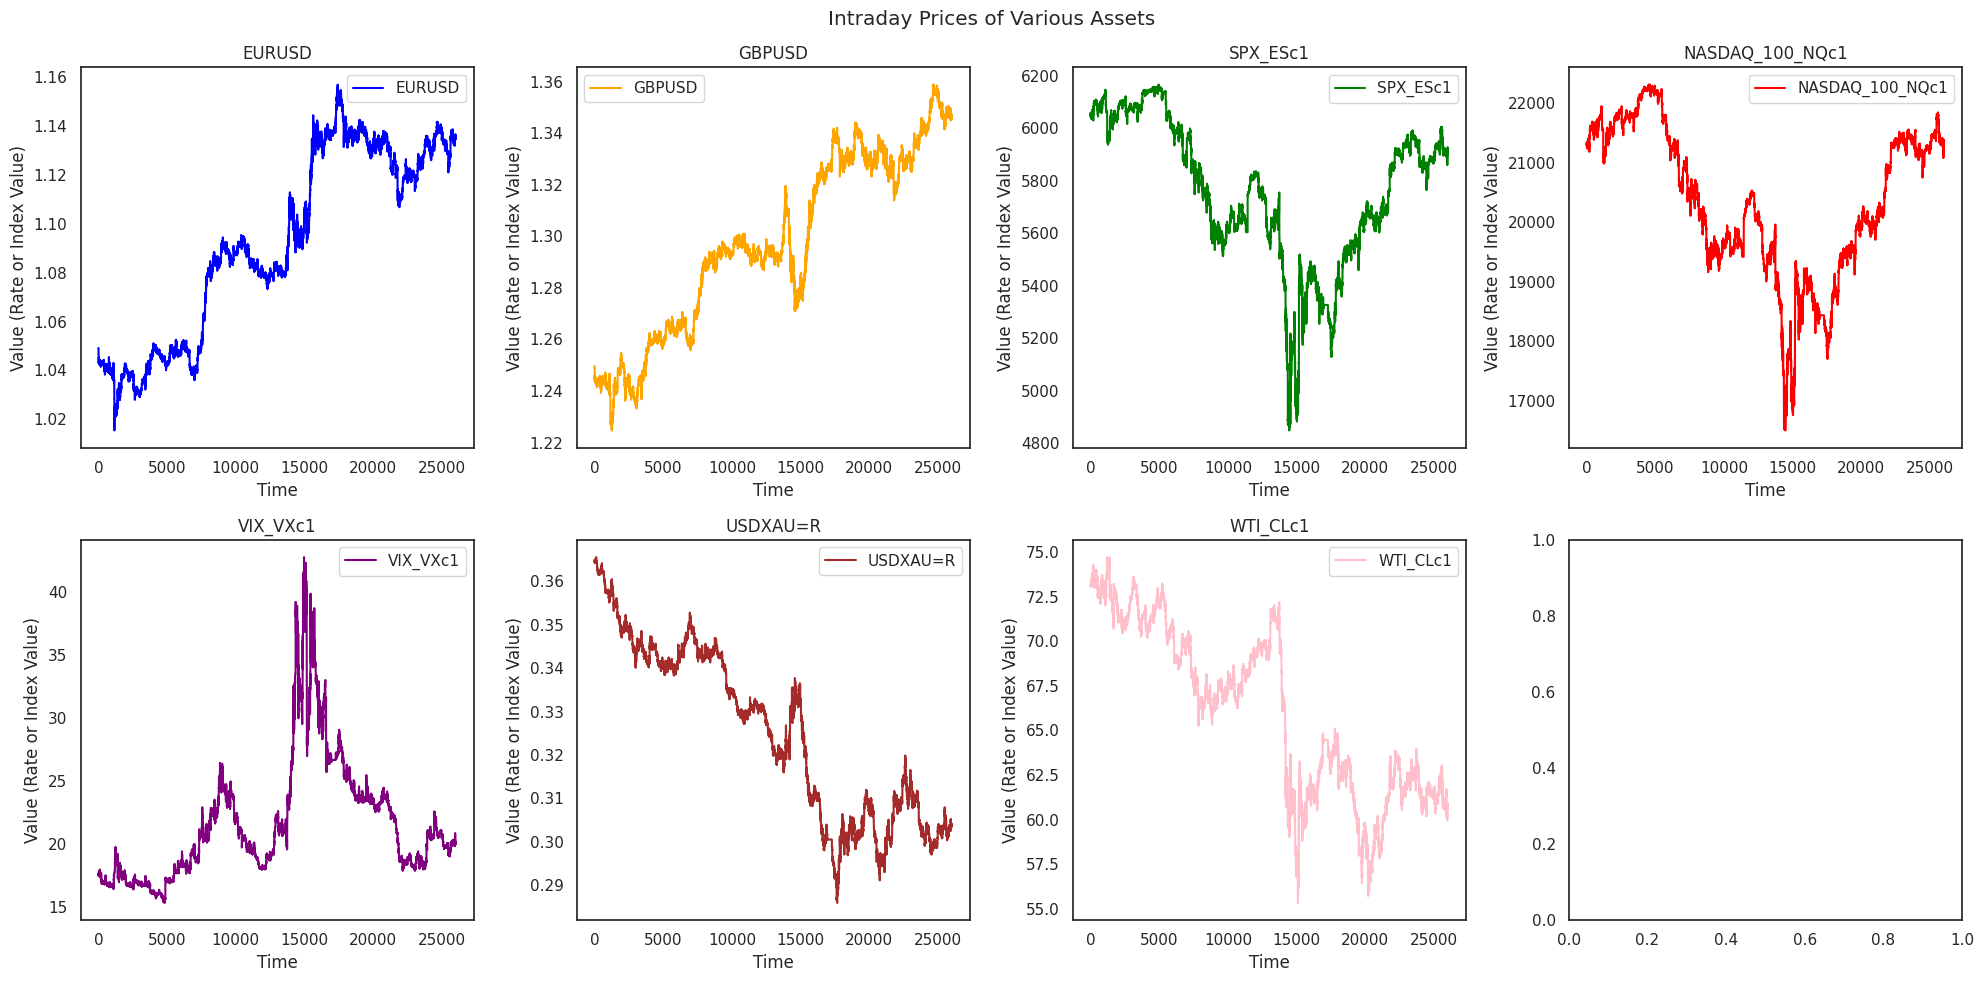

In [ ]:
multi_plot(df, 
            title='Intraday Prices of Various Assets',
            xlabel='Time',
            ylabel='Value (Rate or Index Value)')

This figure presents eight separate time‐series panels arranged in a 2×4 grid. Each panel plots the intraday price for a different asset over the same minute‐by‐minute session, so you can compare how each market moved in parallel through that single trading day.

In [95]:
df = augment_intraday_data(df, 'NASDAQ_100_NQc1_Open')
df = augment_intraday_data(df, 'VIX_VXc1_Open')
df = augment_intraday_data(df, 'SPX_ESc1_Open')
df

,USDXAU=R_Open,WTI_CLc1_Open,GBPUSD_Open,NASDAQ_100_NQc1_Open,VIX_VXc1_Open,EURUSD_Open,SPX_ESc1_Open,NASDAQ_100_NQc1_Open_BOLL_W,NASDAQ_100_NQc1_Open_SMI(StochRSI),NASDAQ_100_NQc1_Open_MACD,...,VIX_VXc1_Open_MTM12,SPX_ESc1_Open_BOLL_W,SPX_ESc1_Open_SMI(StochRSI),SPX_ESc1_Open_MACD,SPX_ESc1_Open_EMA10,SPX_ESc1_Open_EMA20,SPX_ESc1_Open_MA5,SPX_ESc1_Open_MA10,SPX_ESc1_Open_MTM6,SPX_ESc1_Open_MTM12
Exchange Date,,,,,,,,,,,,,,,,,,,,,
2025-01-27 23:50:00,0.36500,73.059998,1.2497,21296.75,17.520000,1.0492,6049.50,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-27 23:55:00,0.36500,73.080002,1.2497,21296.75,17.520000,1.0492,6049.50,NaN,0.000000,NaN,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-28 00:00:00,0.36492,73.150002,1.2496,21296.75,17.510000,1.0492,6049.50,NaN,0.000000,NaN,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-28 00:05:00,0.36458,73.195000,1.2495,21343.25,17.500000,1.0488,6059.50,NaN,0.000000,NaN,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-28 00:10:00,0.36472,73.190002,1.2486,21317.50,17.500000,1.0478,6052.50,NaN,0.000000,NaN,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-30 22:45:00,0.30381,60.785000,1.3459,21362.50,20.049999,1.1345,5913.25,0.280498,0.059279,-1.643804,...,-0.100000,0.338763,0.030690,-0.384086,-0.328427,-0.044034,-0.70,-1.025,15.25,3.75
2025-05-30 22:50:00,0.30373,60.790001,1.3459,21360.75,20.080000,1.1346,5912.50,0.243370,-0.051009,-1.676840,...,-0.070000,0.346279,-0.049900,-0.392426,-0.405077,-0.111269,-0.55,-0.350,19.25,3.50
2025-05-30 22:55:00,0.30372,60.775002,1.3460,21353.00,20.049999,1.1348,5910.25,0.208947,-0.066619,-2.162246,...,-0.150002,0.362090,-0.057011,-0.514146,-0.740517,-0.314958,-0.75,-0.800,18.75,-0.25


In [96]:
print(df.isnull().sum())

USDXAU=R_Open                           0
WTI_CLc1_Open                           0
GBPUSD_Open                             0
NASDAQ_100_NQc1_Open                    0
VIX_VXc1_Open                           0
EURUSD_Open                             0
SPX_ESc1_Open                           0
NASDAQ_100_NQc1_Open_BOLL_W            19
NASDAQ_100_NQc1_Open_SMI(StochRSI)      1
NASDAQ_100_NQc1_Open_MACD              26
NASDAQ_100_NQc1_Open_EMA10             10
NASDAQ_100_NQc1_Open_EMA20             20
NASDAQ_100_NQc1_Open_MA5                5
NASDAQ_100_NQc1_Open_MA10              10
NASDAQ_100_NQc1_Open_MTM6             100
NASDAQ_100_NQc1_Open_MTM12            200
VIX_VXc1_Open_BOLL_W                   19
VIX_VXc1_Open_SMI(StochRSI)             1
VIX_VXc1_Open_MACD                     26
VIX_VXc1_Open_EMA10                    10
VIX_VXc1_Open_EMA20                    20
VIX_VXc1_Open_MA5                       5
VIX_VXc1_Open_MA10                     10
VIX_VXc1_Open_MTM6                

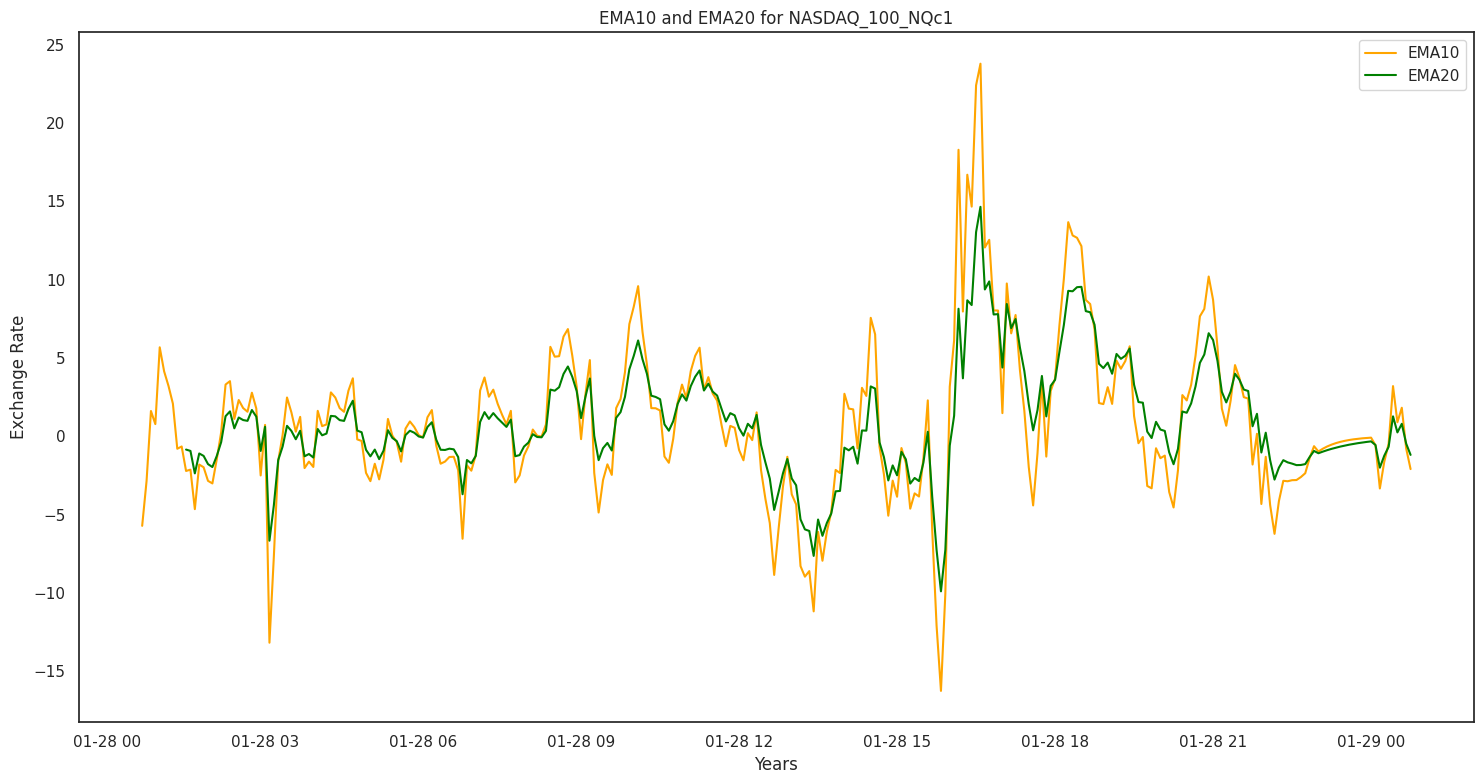

In [97]:
single_plot(df.iloc[:300], 
     data=[df['NASDAQ_100_NQc1_Open_EMA10'].iloc[:300], df['NASDAQ_100_NQc1_Open_EMA20'].iloc[:300]],
     labels=['EMA10','EMA20'],
     colors=['orange', 'green'],
     title="EMA10 and EMA20 for NASDAQ_100_NQc1",
     xlabel="Years",
     ylabel="Exchange Rate",
     figsize=(15, 8))

- EMA10 (orange) = the 10‐bar exponential moving average of the     NASDAQ‐100’s intraday return, which assigns heavier weight to the most recent 10 one‐minute changes.

- EMA20 (green) = the 20‐bar exponential moving average of that same intraday return, smoothing over a wider window and therefore reacting more slowly.

When the orange EMA10 line crosses above the green EMA20, it often indicates that very short‐term upward momentum in the NASDAQ has accelerated faster than the 20-bar average—suggesting a fresh burst of buying. Conversely, when EMA10 falls below EMA20, it implies that recent negative returns are pulling the short‐term trend beneath the longer‐term average-an early warning that the intraday momentum is weakening.

Both EMA10 and EMA20 oscillate around zero here, because they are tracking raw one‐minute returns (which average out to roughly zero over the day). The sharper swings in the orange line show immediate reactions to each minute’s price move, while the smoother green line reflects whether those swings persist long enough to influence the broader 20-minute trend.

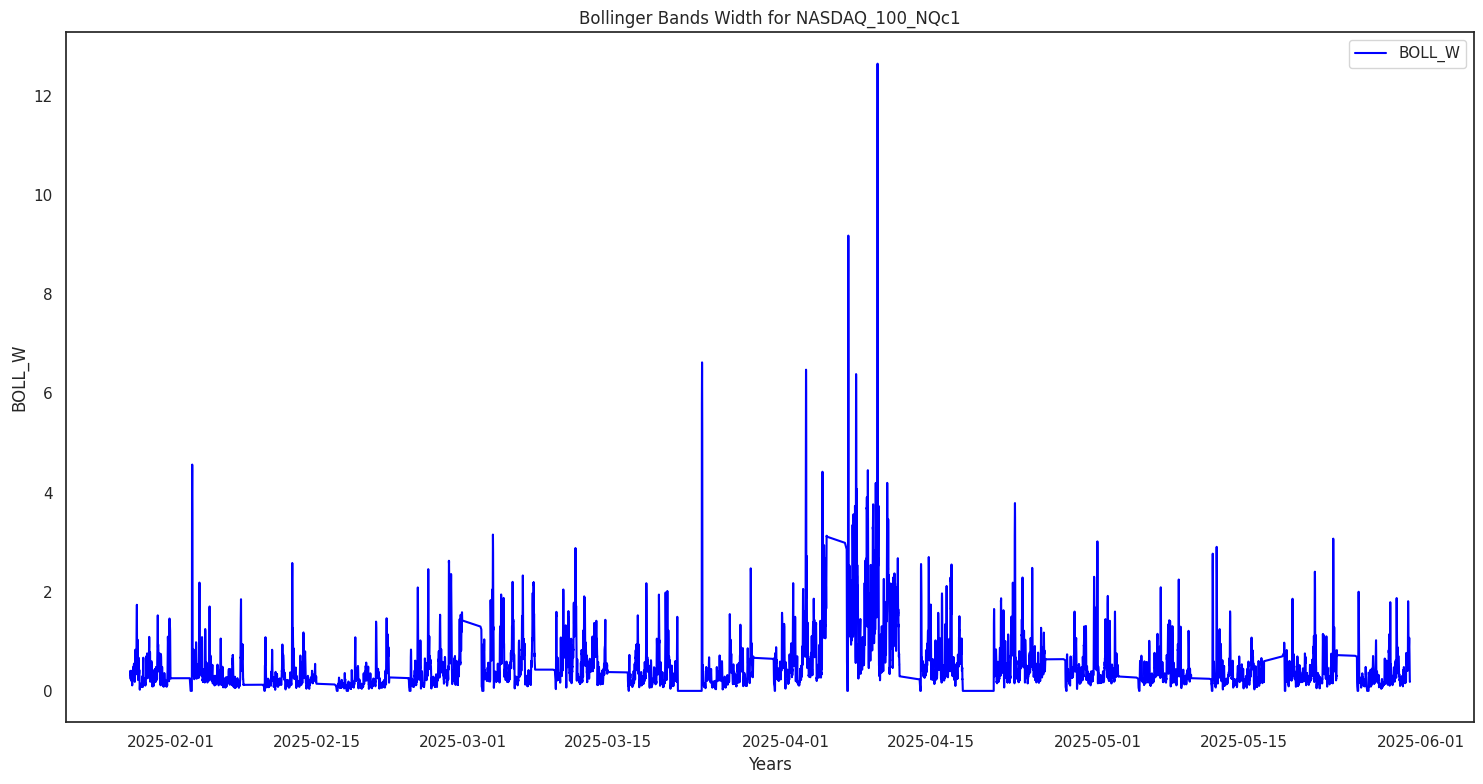

In [98]:
single_plot(df,
        data=[df['NASDAQ_100_NQc1_Open_BOLL_W']],
        labels=['BOLL_W'],
        colors=['blue'],
        title="Bollinger Bands Width for NASDAQ_100_NQc1",
        xlabel="Years",
        ylabel="BOLL_W",
        figsize=(15,8))

This Bollinger Bands width plot for NASDAQ-100 futures shows intraday volatility minute by minute. 

When BOLL_W stays below about 1-2, the market is in a calm, low-volatility state. 

Spikes above 3-4 mark moments of sudden turbulence, with the tallest peak (~12) in mid-April indicating a rapid surge-and-reversal. 

Between those bursts, the width drifts back toward zero, signaling a return to normal, subdued trading conditions.

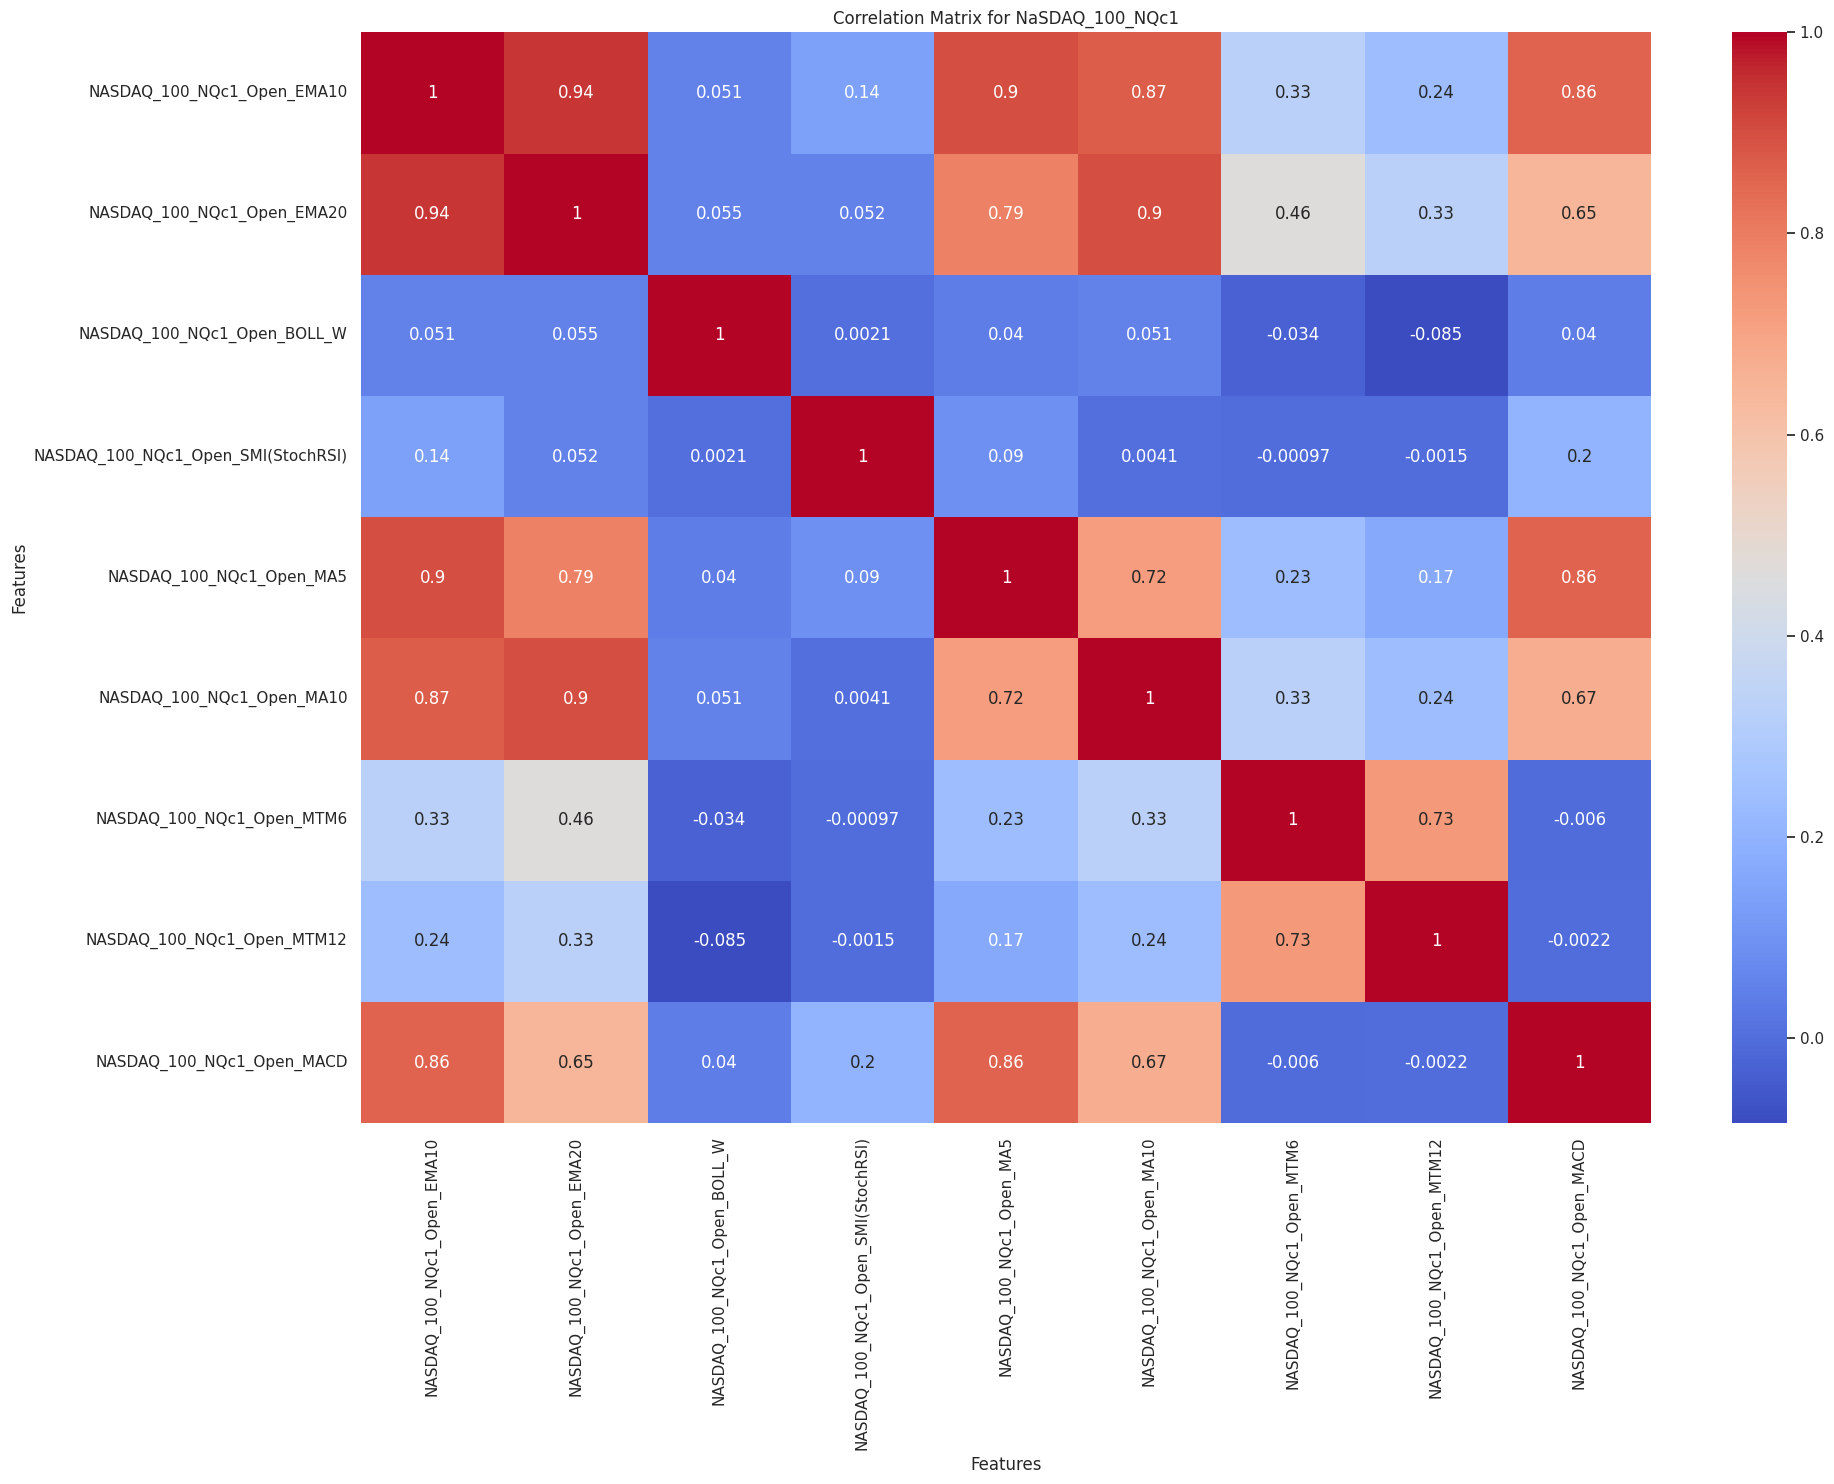

In [ ]:
#Heatmap of the correlation matrix for EURGBP
nasdaq_corr = df[['NASDAQ_100_NQc1_Open_EMA10', 'NASDAQ_100_NQc1_Open_EMA20', 
                  'NASDAQ_100_NQc1_Open_BOLL_W', 'NASDAQ_100_NQc1_Open_SMI(StochRSI)',
                  'NASDAQ_100_NQc1_Open_MA5', 'NASDAQ_100_NQc1_Open_MA10',
                  'NASDAQ_100_NQc1_Open_MTM6', 'NASDAQ_100_NQc1_Open_MTM12',
                  'NASDAQ_100_NQc1_Open_MACD']].corr()
single_plot(nasdaq_corr,
        heatmap=True,
        title="Correlation Matrix for NaSDAQ_100_NQc1",
        xlabel="Features",
        ylabel="Features")

We appreciate some high correlated covariate, but this is expected, since many of them are the output of similar computations from the same initial data. Nontheless, these are still useful for several reasons, some of which we also discussed before (e.g. crosses of MAs).

We now take first differences for all covariates. This should mitigate non-stationarity and help to have consistency among train, validation, and test.

In [100]:
# We take first differences of the basic covariates to make the data stationary
df = first_differences_intraday_data(df)

df = df.dropna()
df = df*100 # Convert to bps
df

,USDXAU=R_Open,WTI_CLc1_Open,GBPUSD_Open,NASDAQ_100_NQc1_Open,VIX_VXc1_Open,EURUSD_Open,SPX_ESc1_Open,NASDAQ_100_NQc1_Open_BOLL_W,NASDAQ_100_NQc1_Open_SMI(StochRSI),NASDAQ_100_NQc1_Open_MACD,...,VIX_VXc1_Open_MTM12,SPX_ESc1_Open_BOLL_W,SPX_ESc1_Open_SMI(StochRSI),SPX_ESc1_Open_MACD,SPX_ESc1_Open_EMA10,SPX_ESc1_Open_EMA20,SPX_ESc1_Open_MA5,SPX_ESc1_Open_MA10,SPX_ESc1_Open_MTM6,SPX_ESc1_Open_MTM12
Exchange Date,,,,,,,,,,,,,,,,,,,,,
2025-01-28 16:30:00,0.002003,0.000000,0.059998,0.267768,-0.582075,0.019991,0.164986,110.026779,0.000000,964.388632,...,-44.000053,62.943322,0.000000,171.698872,369.177358,194.299026,630.0,240.0,3200.0,2175.0
2025-01-28 16:35:00,-0.010002,0.068104,0.039995,0.139940,0.702584,0.010002,0.078237,130.964726,0.000000,974.415871,...,-31.999969,72.658825,0.000000,171.527120,388.417839,221.032452,405.0,337.5,3550.0,2650.0
2025-01-28 16:40:00,0.005001,-0.081670,0.020003,-0.189823,-0.290704,0.000000,-0.086403,140.205294,-16.118750,406.780051,...,-36.000061,77.586272,-11.674798,89.665752,222.341868,149.981742,400.0,355.0,3100.0,2125.0
2025-01-28 16:45:00,-0.005999,-0.088555,0.030005,0.068843,-0.291538,0.000000,0.074124,150.113287,3.197042,400.150504,...,-39.999962,84.065274,5.811246,102.285298,263.734256,178.554910,320.0,462.5,3025.0,1575.0
2025-01-28 16:50:00,-0.002003,-0.115895,-0.080001,-0.057131,0.292397,-0.070000,-0.004113,156.605049,-4.808578,175.011680,...,-35.000038,89.441063,-0.577497,73.115025,211.237118,159.168728,275.0,367.5,2700.0,2250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-30 22:45:00,-0.005999,-0.032890,0.020003,0.009358,-0.149405,-0.019991,0.004232,28.049760,5.927887,-164.380431,...,-10.000038,33.876314,3.069015,-38.408623,-32.842733,-4.403401,-70.0,-102.5,1525.0,375.0
2025-05-30 22:50:00,-0.007999,0.008225,0.000000,-0.008190,0.149632,0.010002,-0.012684,24.337033,-5.100926,-167.684016,...,-6.999969,34.627888,-4.990026,-39.242593,-40.507691,-11.126886,-55.0,-35.0,1925.0,350.0
2025-05-30 22:55:00,-0.001001,-0.024676,0.009990,-0.036281,-0.149405,0.019991,-0.038058,20.894697,-6.661927,-216.224614,...,-15.000153,36.208994,-5.701103,-51.414592,-74.051747,-31.495754,-75.0,-80.0,1875.0,-25.0


In [101]:
for col in df.columns:
    temp = '\t'
    adf = adfuller(df[col])
    if adf[1] < 0.05:
        print(f"{col.ljust(40)} is stationary (p-value: {adf[1]:.6f})")
    else:
        print(f"{col.ljust(40)} is not stationary (p-value: {adf[1]:.6f})")
del temp, adf, col

USDXAU=R_Open                            is stationary (p-value: 0.000000)
WTI_CLc1_Open                            is stationary (p-value: 0.000000)
GBPUSD_Open                              is stationary (p-value: 0.000000)
NASDAQ_100_NQc1_Open                     is stationary (p-value: 0.000000)
VIX_VXc1_Open                            is stationary (p-value: 0.000000)
EURUSD_Open                              is stationary (p-value: 0.000000)
SPX_ESc1_Open                            is stationary (p-value: 0.000000)
NASDAQ_100_NQc1_Open_BOLL_W              is stationary (p-value: 0.000000)
NASDAQ_100_NQc1_Open_SMI(StochRSI)       is stationary (p-value: 0.000000)
NASDAQ_100_NQc1_Open_MACD                is stationary (p-value: 0.000000)
NASDAQ_100_NQc1_Open_EMA10               is stationary (p-value: 0.000000)
NASDAQ_100_NQc1_Open_EMA20               is stationary (p-value: 0.000000)
NASDAQ_100_NQc1_Open_MA5                 is stationary (p-value: 0.000000)
NASDAQ_100_NQc1_Open_MA10

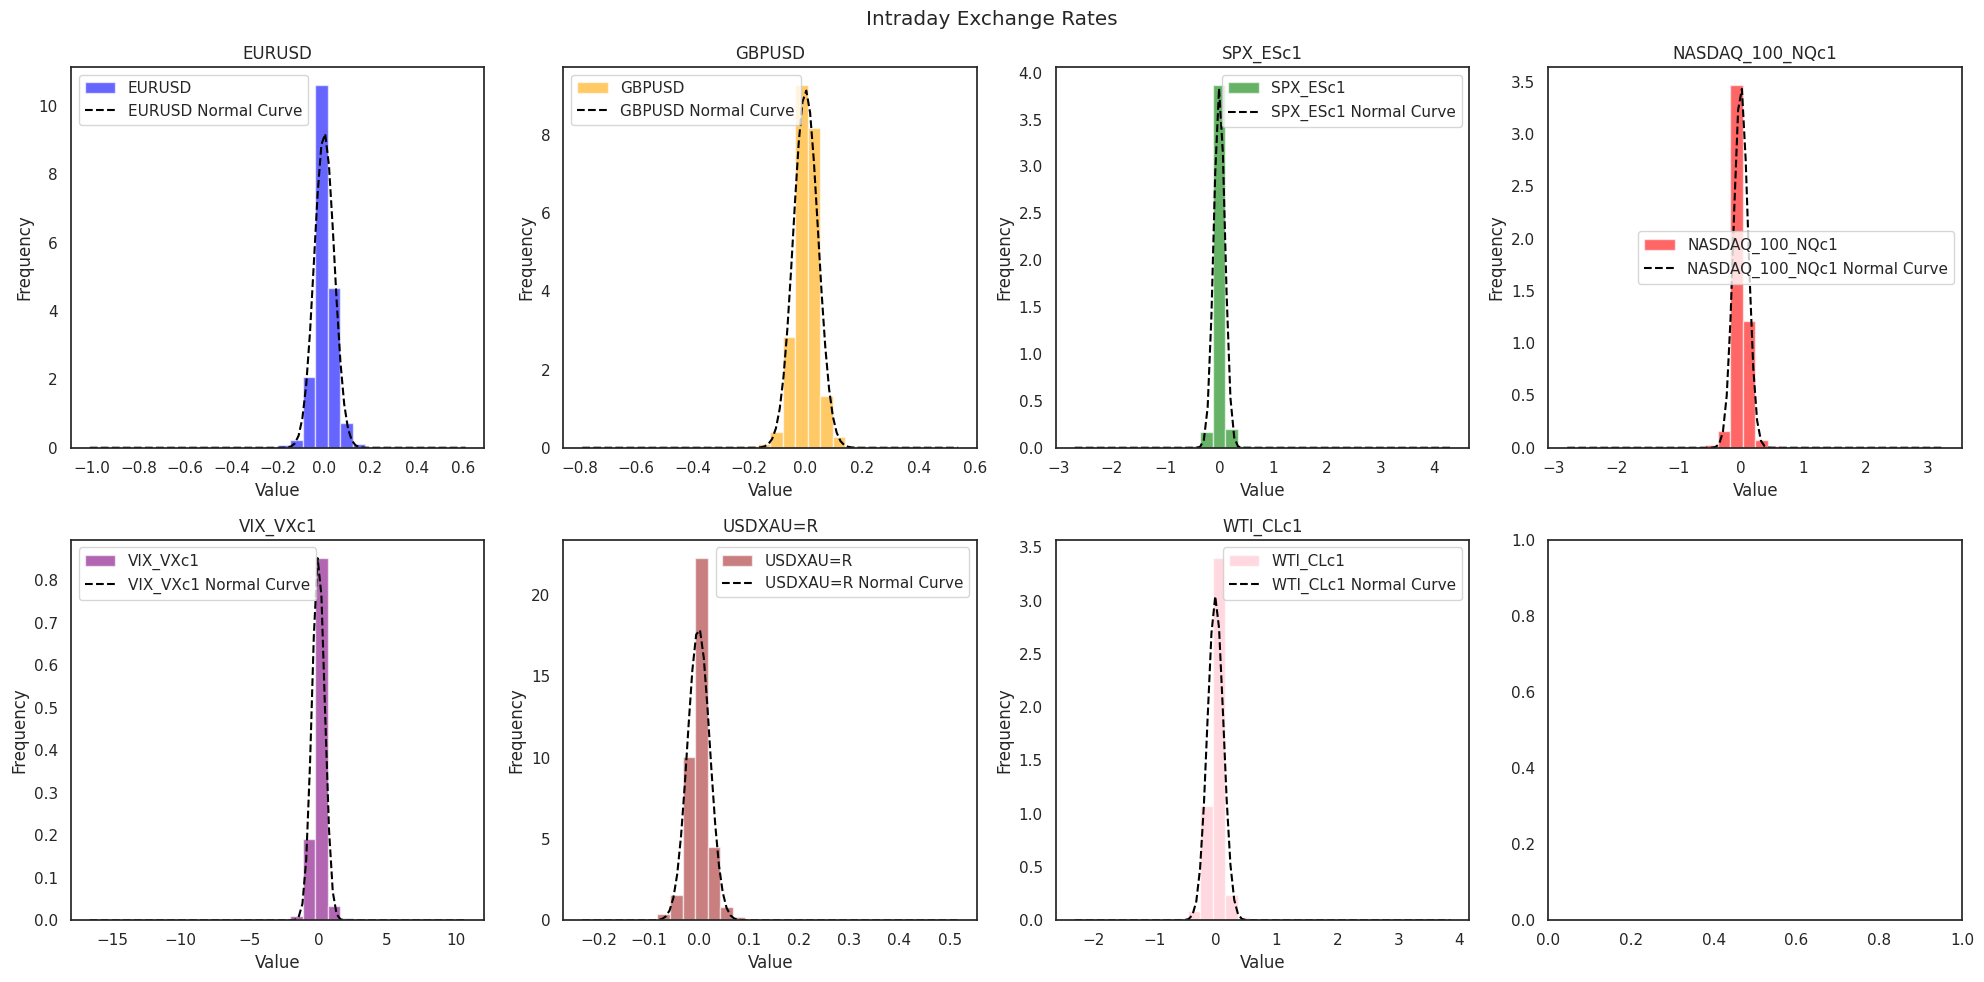

In [102]:
multi_plot(df, 
            title='Intraday Exchange Rates',
            xlabel='Value',
            ylabel='Frequency',
            plot_type='histogram')

Each histogram shows that the intraday return differences closely follow a bell‐shaped curve-most returns hover near zero with progressively fewer extremes-indicating that these daily changes are approximately normally distributed.

## Split and Standardize

In [103]:
TRAIN_SIZE = 0.84
VAL_SIZE = 0.08
TEST_SIZE = 0.08

train_idx = int(len(df) * TRAIN_SIZE)
val_idx = train_idx + int(len(df) * VAL_SIZE)

df_train = df[:train_idx]
df_val = df[train_idx:val_idx]
df_test = df[val_idx:]

x_train = df_train.drop(columns=['NASDAQ_100_NQc1_Open']).values
x_val   = df_val.drop(columns=['NASDAQ_100_NQc1_Open']).values
x_test  = df_test.drop(columns=['NASDAQ_100_NQc1_Open']).values

y_train = df_train['NASDAQ_100_NQc1_Open'].values
y_val = df_val['NASDAQ_100_NQc1_Open'].values
y_test = df_test['NASDAQ_100_NQc1_Open'].values

PRICE_NASDAQ_TRAIN = df_train['NASDAQ_100_NQc1_Open'].values
PRICE_NASDAQ_VAL = df_val['NASDAQ_100_NQc1_Open'].values
PRICE_NASDAQ_TEST = df_test['NASDAQ_100_NQc1_Open'].values

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

df_val

(21691, 33) (21691,)
(2065, 33) (2065,)
(2067, 33) (2067,)


,USDXAU=R_Open,WTI_CLc1_Open,GBPUSD_Open,NASDAQ_100_NQc1_Open,VIX_VXc1_Open,EURUSD_Open,SPX_ESc1_Open,NASDAQ_100_NQc1_Open_BOLL_W,NASDAQ_100_NQc1_Open_SMI(StochRSI),NASDAQ_100_NQc1_Open_MACD,...,VIX_VXc1_Open_MTM12,SPX_ESc1_Open_BOLL_W,SPX_ESc1_Open_SMI(StochRSI),SPX_ESc1_Open_MACD,SPX_ESc1_Open_EMA10,SPX_ESc1_Open_EMA20,SPX_ESc1_Open_MA5,SPX_ESc1_Open_MA10,SPX_ESc1_Open_MTM6,SPX_ESc1_Open_MTM12
Exchange Date,,,,,,,,,,,,,,,,,,,,,
2025-05-12 18:45:00,-0.011998,0.064182,0.019991,-0.007200,-0.263155,-0.010002,0.017142,40.841073,-2.643911,183.681026,...,-225.000000,31.694203,5.552411,52.415315,104.468688,59.319277,125.0,115.0,975.0,8800.0
2025-05-12 18:50:00,-0.003999,-0.208449,0.040007,0.080407,0.000000,0.049996,0.085711,46.475587,10.199836,272.804044,...,-219.999878,35.511118,7.225128,80.927346,176.383472,101.288870,235.0,187.5,2025.0,9000.0
2025-05-12 18:55:00,0.030997,0.096405,-0.050008,0.098324,0.000000,-0.059998,0.081360,54.011433,0.000000,369.435422,...,-215.999985,43.389628,0.000000,100.349280,230.677386,136.880406,185.0,255.0,1975.0,9200.0
2025-05-12 19:00:00,-0.009999,0.016057,-0.059998,0.025153,0.052762,-0.039995,0.059903,61.356676,0.000000,319.281255,...,-219.000061,52.129311,0.000000,104.450804,252.372407,157.177510,360.0,252.5,2375.0,10000.0
2025-05-12 19:05:00,0.018001,-0.080252,-0.049996,0.015569,0.000000,-0.040007,0.004280,67.534799,0.000000,260.393730,...,-209.000015,59.175097,0.000000,80.548000,211.031969,144.589176,290.0,200.0,2325.0,10050.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-21 20:35:00,0.005001,-0.097424,0.000000,0.140262,-0.242126,0.000000,0.102103,206.234050,19.640904,217.566311,...,247.000122,168.449482,17.952237,40.323175,-118.096890,-183.535422,45.0,-245.0,-2975.0,-6750.0
2025-05-21 20:40:00,-0.013000,-0.024384,0.000000,0.130641,-0.728154,0.019991,0.114751,183.245175,3.246688,463.456968,...,232.000153,149.546798,9.120222,102.594750,26.102545,-101.770143,-45.0,-42.5,-2350.0,-5975.0
2025-05-21 20:45:00,0.000998,0.105679,0.020003,-0.065827,0.293398,0.000000,-0.067925,160.845290,-8.477986,317.776349,...,238.000107,131.475194,-12.236017,64.458865,-51.370645,-130.172987,45.0,-105.0,-2650.0,-6300.0


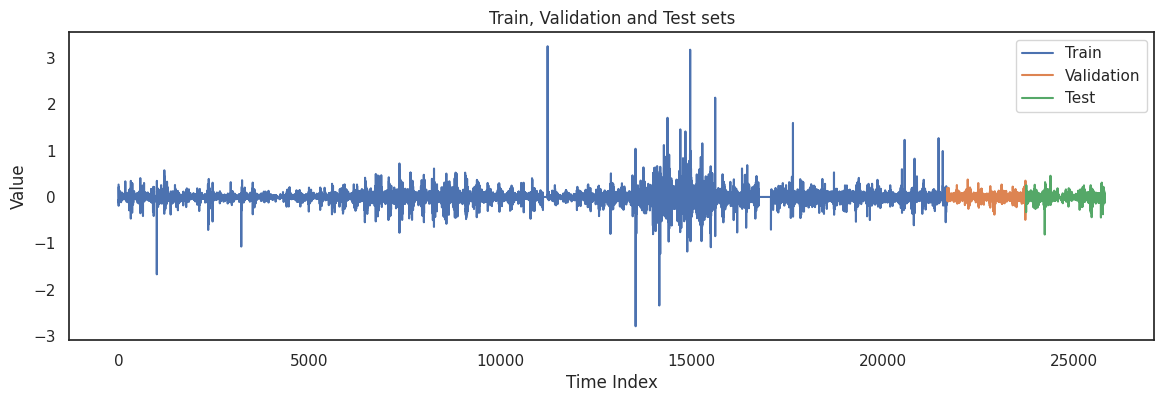

In [104]:
plt.figure(figsize=(14, 4))
plt.plot(np.arange(len(y_train)), y_train, label='Train')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, label='Validation')
plt.plot(np.arange(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test)), y_test, label='Test')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.title('Train, Validation and Test sets')
plt.show()

This single‐line chart shows how the NASDAQ return series is split into three consecutive segments: train, validation, and test.

We can see that the training portion captures the biggest spikes and troughs, while validation and test follow afterward when volatility is more subdued. This is problematic: we want the training set to best resemble validation and test.

For this reason, we split the data in two different volatility regimes (high and low) and train different models on each of them. We ensure no look-ahead bies is introduced by computing the threshold for assigning the regime only on the train set.

## Data Preprocessing
We preprocess the data just by scaling them. In this case we don't apply the Discrete Wavelet transform because the higher freqency of the data could mean that the transformation would remove too much of the little signal present in the series, instead of safely removing the noise

In [105]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

print(x_train_scaled.shape, y_train.shape)

(21691, 33) (21691,)


In [106]:
# --- Find contiguous blocks for each regime ---
def contiguous_blocks(arr):
    """Yield (start, end) indices for contiguous blocks of the same value in arr."""
    blocks = []
    start = 0
    for i in range(1, len(arr)):
        if arr[i] != arr[i-1]:
            blocks.append((arr[start], start, i))  # (regime, start, end)
            start = i
    blocks.append((arr[start], start, len(arr)))
    return blocks

def merge_short_blocks(blocks, min_length=24):
    """
    Merge blocks shorter than min_length with the previous block.
    blocks: list of (regime, start, end)
    Returns: new list of (regime, start, end)
    """
    if not blocks:
        return []
    merged = [blocks[0]]
    for regime, start, end in blocks[1:]:
        prev_regime, prev_start, prev_end = merged[-1]
        if (end - start) < min_length:
            # Merge with previous block (extend previous block's end)
            merged[-1] = (prev_regime, prev_start, end)
        else:
            merged.append((regime, start, end))
    return merged

In [107]:
# --- Parameters ---
window_vol = 50  # rolling window for volatility
n_regimes = 2    # number of regimes (quantiles)

# --- train regime assignment ---
volatility_train = pd.Series(y_train).rolling(window_vol, min_periods=window_vol).std().fillna(0)
regime_bins_train = pd.qcut(volatility_train, q=n_regimes, labels=False, duplicates='drop')
regime_bins_train = regime_bins_train.values

# --- Compute quantile thresholds on train volatility for use in validation ---
vol_quantiles = np.quantile(volatility_train, [i / n_regimes for i in range(1, n_regimes)])

# --- validation regime assignment (using train quantiles) ---
volatility_val = pd.Series(y_val).rolling(window_vol).std().fillna(0)
regime_bins_val = np.digitize(volatility_val, vol_quantiles)



# --- Find and merge short blocks ---
blocks_train = merge_short_blocks(contiguous_blocks(regime_bins_train), min_length=24)
blocks_val = merge_short_blocks(contiguous_blocks(regime_bins_val), min_length=24)

regime_blocks_train = {regime: [] for regime in range(n_regimes)}
for regime, start, end in blocks_train:
    regime_blocks_train[regime].append((start, end))

regime_blocks_val = {regime: [] for regime in range(n_regimes)}
for regime, start, end in blocks_val:
    regime_blocks_val[regime].append((start, end))

# --- Print block info ---
for regime in range(n_regimes):
    print(f"Train Regime {regime}: {len(regime_blocks_train[regime])} contiguous blocks")
    print(f"Val Regime {regime}: {len(regime_blocks_val[regime])} contiguous blocks \n")

Train Regime 0: 72 contiguous blocks
Val Regime 0: 8 contiguous blocks 

Train Regime 1: 79 contiguous blocks
Val Regime 1: 9 contiguous blocks 



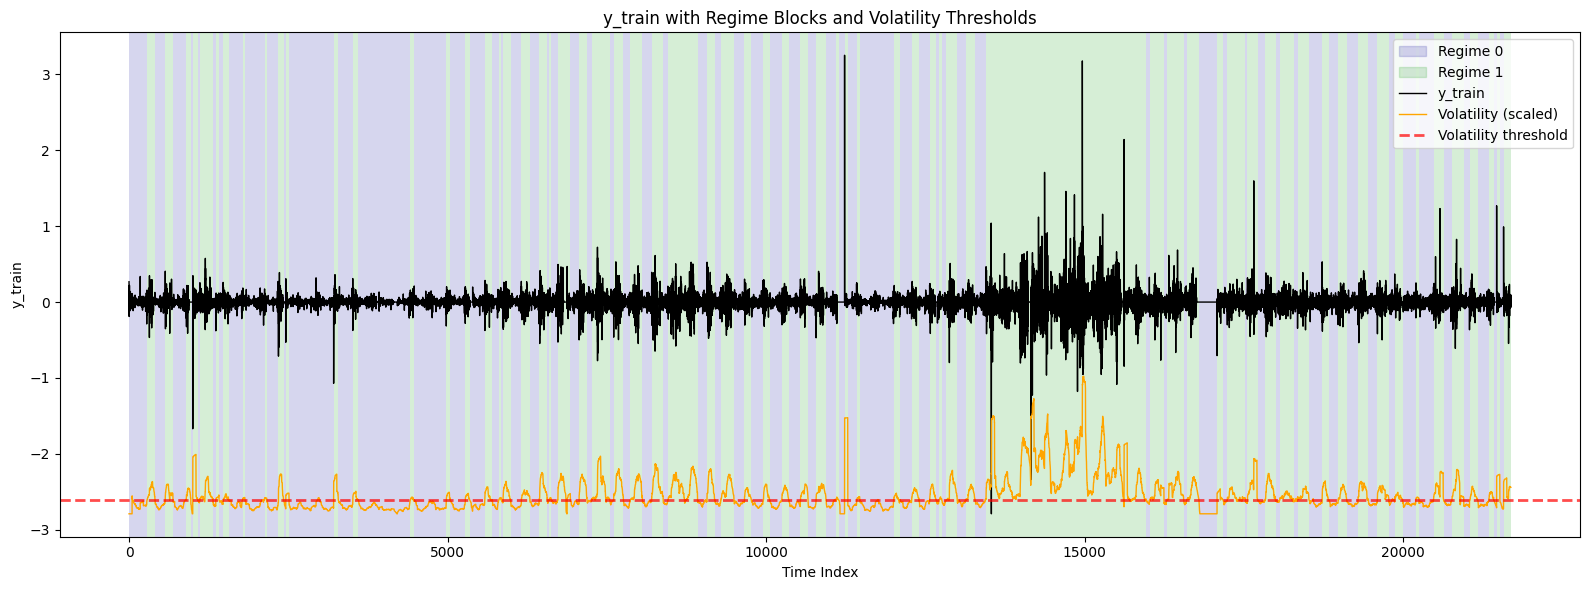

In [15]:
# Plot y_train with regime blocks and volatility thresholds
def plot_regime_blocks(y_train, regime_blocks_train, volatility_train, vol_quantiles):
    fig, ax1 = plt.subplots(figsize=(16, 6))

    # Plot target
    ax1.plot(np.arange(len(y_train)), y_train, color='black', lw=1, label='y_train')

    # Colors for regimes
    regime_colors = ['#3333aa', '#33aa33', '#aa3333']

    # Overlay regime blocks
    for regime, blocks in regime_blocks_train.items():
        for start, end in blocks:
            ax1.axvspan(start, end, color=regime_colors[regime], alpha=0.2, lw=0)

    # Plot volatility (scaled for visibility)
    volatility_scaled = (volatility_train - np.nanmin(volatility_train)) / (np.nanmax(volatility_train) - np.nanmin(volatility_train))
    volatility_scaled = volatility_scaled * (np.nanmax(y_train) - np.nanmin(y_train)) * 0.3 + np.nanmin(y_train)
    ax1.plot(np.arange(len(volatility_train)), volatility_scaled, color='orange', lw=1, label='Volatility (scaled)')

    # Plot volatility thresholds
    for thresh in vol_quantiles:
        thresh_scaled = (thresh - np.nanmin(volatility_train)) / (np.nanmax(volatility_train) - np.nanmin(volatility_train))
        thresh_y = thresh_scaled * (np.nanmax(y_train) - np.nanmin(y_train)) * 0.3 + np.nanmin(y_train)
        ax1.axhline(y=thresh_y, color='red', linestyle='--', lw=2, alpha=0.7, label='Volatility threshold' if 'Volatility threshold' not in ax1.get_legend_handles_labels()[1] else "")

    # Legend for regimes
    regime_patches = [mpatches.Patch(color=regime_colors[i], alpha=0.2, label=f'Regime {i}') for i in range(n_regimes)]
    handles, labels = ax1.get_legend_handles_labels()
    handles = regime_patches + handles
    labels = [f'Regime {i}' for i in range(n_regimes)] + labels

    ax1.set_title('y_train with Regime Blocks and Volatility Thresholds')
    ax1.set_xlabel('Time Index')
    ax1.set_ylabel('y_train')
    ax1.legend(handles, labels, loc='upper right', fontsize=10)
    plt.tight_layout()
    plt.show()
    
plot_regime_blocks(y_train, regime_blocks_train, volatility_train, vol_quantiles)

This chart shows the split of the training data into low and high-volatility regimes based on the computed threshold.

- Blue (Regime 0):
     indicates low-volatility periods, when the scaled volatility (orange line) stays below the threshold. During these stretches, the black return series remains tightly clustered around zero with only small blips.

- Green (Regime 1):
     indicates high-volatility periods, when the orange volatility line rises above the threshold. In those green segments, the black return series exhibits much larger spikes and more frequent outliers.

As soon as the orange volatility spikes above the red dashed cutoff, the background turns green-signaling a switch into a high‐volatility regime. Once volatility drops back below the cutoff, the background switches back to blue, marking a return to calmer, low‐volatility conditions.

## Forecasting

### LSTM - Base model

As we did with the daily data, we first fit a baseline LSTM model. Then, we will try to find an optimal one through hyperparameter optimization.

In [108]:
#for each regime, create sequences based on the blocks
def create_sequences(data, targets, blocks, seq_len=20):
    """
    Create sequences of data and corresponding labels based on contiguous blocks of regimes.
    Args:
        data (np.ndarray): The input data array.
        targets (np.ndarray): The target values array.
        blocks (dict): A dictionary where keys are regime labels and values are lists of (start, end) tuples.
        seq_len (int): Length of each sequence to create.
    Returns:
        np.ndarray: Array of sequences.
        np.ndarray: Array of labels corresponding to the sequences.
    """
    sequences = []
    labels = []
    for regime, block_list in blocks.items():
        for start, end in block_list:
            for i in range(start, end - seq_len):
                seq = data[i:i + seq_len - 1]
                label = targets[i + seq_len]
                sequences.append(seq)
                labels.append(label)
    return np.array(sequences), np.array(labels)

Note that in this case we have to train two different models: one for each regime. then, at prediction time we will identify and use the appropriate one for every timestep $t$, after evaluating the rolling standard deviation with previous time steps.

In [109]:
def train_regimes(x_train_scaled, y_train, regime_blocks_train,
                  x_val_scaled, y_val, regime_blocks_val,
                  input_dim, seq_len=20, hidden_size=1024, nb_layers=1, dropout=0.0,
                  batch_size=64, n_epochs=100, device=None, probabilistic=False):
    """
    Train LSTM models for each regime using the provided training and validation data.
    Args:
        x_train_scaled (np.ndarray): Scaled training features.
        y_train (np.ndarray): Training target values.
        regime_blocks_train (dict): Dictionary with regime blocks for training.
        x_val_scaled (np.ndarray): Scaled validation features.
        y_val (np.ndarray): Validation target values.
        regime_blocks_val (dict): Dictionary with regime blocks for validation.
        input_dim (int): Number of input features.
        seq_len (int): Length of input sequences.
        hidden_size (int): Size of the LSTM hidden layer.
        nb_layers (int): Number of LSTM layers.
        dropout (float): Dropout rate for LSTM layers.
        batch_size (int): Batch size for training.
        n_epochs (int): Number of epochs to train each model.
        device (torch.device): Device to run the model on (CPU or GPU).
    Returns:
        regime_models (dict): Dictionary with trained models and their loss history for each regime.
    """
    regime_models = {}
    for regime in range(n_regimes):
        print(f"\nTraining model for regime {regime}...")

        x_seq_train, y_seq_train = create_sequences(x_train_scaled, y_train, {regime: regime_blocks_train[regime]}, seq_len=seq_len)
        x_seq_val, y_seq_val = create_sequences(x_val_scaled, y_val, {regime: regime_blocks_val[regime]}, seq_len=seq_len)

        print(f"  Train: {x_seq_train.shape}, Val: {x_seq_val.shape}")
        if len(x_seq_train) == 0 or len(x_seq_val) == 0:
            print(f"  No train or val data for regime {regime}, skipping.")
            continue
        
        x_seq_train_torch = torch.from_numpy(x_seq_train.astype(np.float32)).to(device)
        y_seq_train_torch = torch.from_numpy(y_seq_train.astype(np.float32)).to(device)
        x_seq_val_torch = torch.from_numpy(x_seq_val.astype(np.float32)).to(device)
        y_seq_val_torch = torch.from_numpy(y_seq_val.astype(np.float32)).to(device)
        
        train_loader = DataLoader(TensorDataset(x_seq_train_torch, y_seq_train_torch), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(x_seq_val_torch, y_seq_val_torch), batch_size=batch_size, shuffle=False)
        
        # Iniztialize and train the model
        model = LSTMRegressor(nb_features=input_dim, hidden_size=hidden_size, nb_layers=nb_layers, dropout=dropout, device=device, probabilistic=probabilistic).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        if probabilistic:
            loss_fn = nn.GaussianNLLLoss()
        else:
            loss_fn = nn.SmoothL1Loss(beta=1.0)
        
        train_loss_series, val_loss_series = train_LSTM(model, train_loader, val_loader, loss_fn, optimizer, n_epochs=n_epochs, verbose=False)
        
        # Store model and losses
        regime_models[regime] = {
            'model': model,
            'train_loss': train_loss_series,
            'val_loss': val_loss_series
        }

    print("\nAll regime-specific models are trained and validated.")
    
    return regime_models

In [110]:
input_dim = x_train_scaled.shape[1]
seq_len = 20

hidden_size = 2048
dropout = 0.0
nb_layers = 1

batch_size = 1024
n_epochs = 30


# --- Train regime-specific models and validate ---
regime_models = train_regimes(x_train_scaled, y_train, regime_blocks_train, x_val_scaled, y_val, regime_blocks_val, seq_len=seq_len,
                              input_dim=input_dim, hidden_size=hidden_size, nb_layers=nb_layers, dropout=dropout,
                              batch_size=batch_size, n_epochs=n_epochs, device=device, probabilistic=True)


Training model for regime 0...
  Train: (9288, 19, 33), Val: (1359, 19, 33)
Training on cuda:0
Epoch 1/30 — Train loss: -0.05665283 | Val loss: -0.32858689
Epoch 20/30 — Train loss: -1.37345658 | Val loss: -1.76606235
Epoch 30/30 — Train loss: -2.38123354 | Val loss: -2.36260791
Restored best model weights (val loss: -2.54458581)

Training model for regime 1...
  Train: (9383, 19, 33), Val: (366, 19, 33)
Training on cuda:0
Epoch 1/30 — Train loss: -0.04930668 | Val loss: -0.16177501
Epoch 20/30 — Train loss: -1.49945493 | Val loss: -2.01532578
Epoch 30/30 — Train loss: -1.59207631 | Val loss: -2.04646444
Restored best model weights (val loss: -2.08990455)

All regime-specific models are trained and validated.


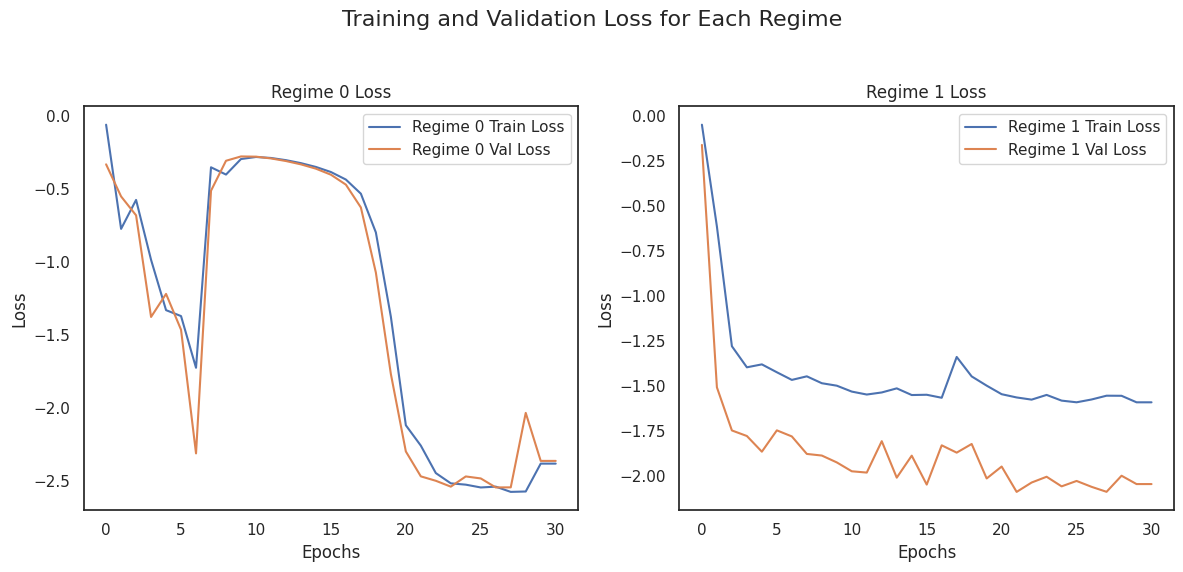

In [112]:
def plot_regime_losses(regime_models, n_regimes):
    fig, ax = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)#, sharex=True, sharey=True)
    for i in range(n_regimes):
        if i in regime_models:
            ax[i].plot(regime_models[i]['train_loss'], label=f'Regime {i} Train Loss')
            ax[i].plot(regime_models[i]['val_loss'], label=f'Regime {i} Val Loss')
            ax[i].set_xlabel('Epochs')
            ax[i].set_ylabel('Loss')
            ax[i].set_title(f'Regime {i} Loss')
            ax[i].legend()
    plt.tight_layout()
    plt.suptitle('Training and Validation Loss for Each Regime', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_regime_losses(regime_models, n_regimes)

These charts indicate that the loss landscape is much rougher than in the daily-data case. This means are facing a harder optimization problem.

In [113]:
def predict_by_regime(regime_models, x_test_scaled, y_test, vol_quantiles, seq_len, window_vol=50, device=None):
    """
    For each test sample, determine its regime and use the corresponding model for prediction.
    Returns arrays of predictions and true values (aligned).
    """
    # Compute rolling volatility for test set
    volatility_test = pd.Series(y_test).rolling(window_vol, min_periods=window_vol).std().fillna(0)
    regime_bins_test = np.digitize(volatility_test, vol_quantiles)
    
    preds = []
    trues = []
    for i in range(seq_len, len(x_test_scaled)):
        regime = regime_bins_test[i]
        if regime not in regime_models:
            # If no model for this regime, skip
            continue
        model = regime_models[regime]['model']
        # Prepare sequence for LSTM: shape (1, seq_len, features)
        seq_x = x_test_scaled[i-seq_len:i].astype(np.float32)
        seq_x_torch = torch.from_numpy(seq_x).unsqueeze(0).to(device)
        model.eval()
        with torch.no_grad():
            if model.style == 'probabilistic':
                # For probabilistic model, get mean prediction
                pred, _ = model(seq_x_torch)
                pred = pred.cpu().numpy().flatten()[0]
            else:
                pred = model(seq_x_torch).cpu().numpy().flatten()[0]
        preds.append(pred)
        trues.append(y_test[i])
    return np.array(preds), np.array(trues)

(2047,) (2047,)
Test R2: 0.011969


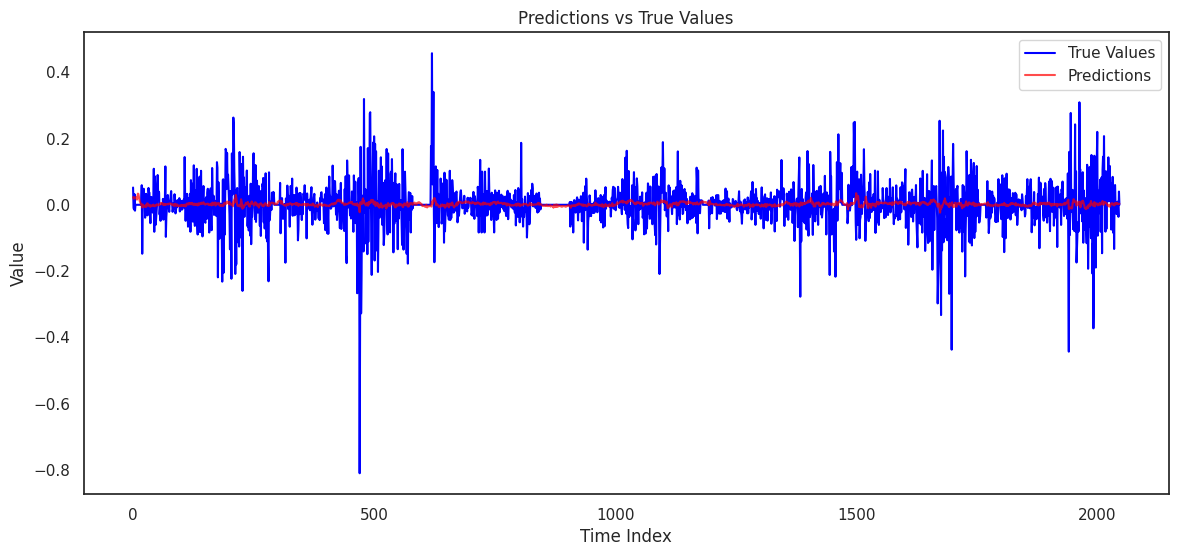

In [ ]:
# --- Assign regimes to test set using train quantiles ---
volatility_test = pd.Series(y_test).rolling(window_vol, min_periods=window_vol).std().fillna(0)
regime_bins_test = np.digitize(volatility_test, vol_quantiles)
blocks_test = contiguous_blocks(regime_bins_test)
regime_blocks_test = {regime: [] for regime in range(n_regimes)}
for regime, start, end in blocks_test:
    regime_blocks_test[regime].append((start, end))

# --- Get predictions and true values ---
predictions, y_seq_test = predict_by_regime(regime_models, x_test_scaled, y_test, vol_quantiles, seq_len=seq_len, window_vol=window_vol, device=device)
print(predictions.shape, y_seq_test.shape)
print(f"Test R2: {r2_score(y_seq_test, predictions):.6f}")
# --- Plot predictions vs true values ---
def plot_predictions_vs_true(predictions, y_seq_test):
    plt.figure(figsize=(14, 6))
    plt.plot(y_seq_test, label='True Values', color='blue', alpha=1)
    plt.plot(predictions, label='Predictions', color='red', alpha=0.7)
    plt.xlabel('Time Index')
    plt.ylabel('Value')
    plt.title('Predictions vs True Values')
    plt.legend()
    plt.show()

plot_predictions_vs_true(predictions, y_seq_test)

the model is almost predicting the mean. This is sign of underfitting.

In [115]:
# compute the same loss as in training
def compute_loss(predictions, y_true):
    """
    Compute the Smooth L1 loss between predictions and true values.
    """
    predictions_torch = torch.from_numpy(predictions.astype(np.float32)).to(device)
    y_true_torch = torch.from_numpy(y_true.astype(np.float32)).to(device)
    loss_fn = nn.SmoothL1Loss(beta=1.0)
    return loss_fn(predictions_torch, y_true_torch).item()
# Compute loss on test set
test_loss = compute_loss(predictions, y_seq_test)
print(f"Test Loss: {test_loss:.6f}")

Test Loss: 0.002383


Overall, with this baseline model we get very poor predictions, resulting from heavy underfitting.

### Hyperparameter Tuning - LSTM Model

We now try to find the best model among several possible configuration. We define a parameter grid and fit each model one a time.

In [ ]:
from sklearn.model_selection import ParameterGrid

regime_best_models = {}

regression_styles = ['probabilistic', 'standard']
param_grid = {
    'hidden_size': [2048, 1024, 512],
    'nb_layers': [4, 2, 1],
    'dropout': [0.1],
    'lr': [1e-4],
    'batch_size': [128],
    'n_epochs': [40]
}


for style in regression_styles:
    print(f"\n######## Hyperparameter tuning for regression style: {style} ########\n")

    if style == 'standard':
        loss_fn = nn.SmoothL1Loss(beta=1.0)
    elif style == 'probabilistic':
        loss_fn = nn.GaussianNLLLoss()
    
    best_val_loss = float('inf')
    best_params = None
    best_model = None
    
    _train_series = None
    best_val_series = None

        
    for params in ParameterGrid(param_grid):
        print(f"    Testing params: {params}")
        model = torch.compile(LSTMRegressor(
            nb_features=input_dim,
            hidden_size=params['hidden_size'],
            nb_layers=params['nb_layers'],
            dropout=params['dropout'],
            device=device,
            probabilistic=(style == 'probabilistic')
        ).to(device))

        optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

        validation_losses = []
        for regime in range(n_regimes):
            print(f"\n=== Hyperparameter tuning for regime {regime} === \n")

            # Prepare regime-specific sequences
            x_seq_train, y_seq_train = create_sequences(
                x_train_scaled, y_train, {regime: regime_blocks_train[regime]}, seq_len=seq_len)
            x_seq_val, y_seq_val = create_sequences(
                x_val_scaled, y_val, {regime: regime_blocks_val[regime]}, seq_len=seq_len)

            if len(x_seq_train) == 0 or len(x_seq_val) == 0:
                print(f"  No train or val data for regime {regime}, skipping.")
                continue

            x_seq_train_torch = torch.from_numpy(x_seq_train.astype(np.float32)).to(device)
            y_seq_train_torch = torch.from_numpy(y_seq_train.astype(np.float32)).to(device)
            x_seq_val_torch = torch.from_numpy(x_seq_val.astype(np.float32)).to(device)
            y_seq_val_torch = torch.from_numpy(y_seq_val.astype(np.float32)).to(device)


            train_loader = DataLoader(TensorDataset(x_seq_train_torch, y_seq_train_torch),
                                     batch_size=params['batch_size'], shuffle=True, pin_memory=False)
            val_loader = DataLoader(TensorDataset(x_seq_val_torch, y_seq_val_torch),
                                   batch_size=params['batch_size'], shuffle=False, pin_memory=False)

            train_loss_series, val_loss_series = train_LSTM(model, train_loader, val_loader, 
                                                loss_fn, optimizer, n_epochs=params['n_epochs'], 
                                                verbose=False)
            
            val_loss = val_loss_series[-1]
            print(f"      Validation loss: {val_loss:.6f}")
            validation_losses.append(val_loss)

        val_loss = np.mean(validation_losses)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = params
            best_model = model
            best_train_series = train_loss_series
            best_val_series = val_loss_series


    regime_best_models[(style)] = {
        'model': best_model,
        'train_series': best_train_series,
        'val_series': best_val_series,
        'best_params': best_params,
        'best_val_loss': best_val_loss,
    }
    print(f"  Best params for style {style}: {best_params} \n")
    print(f"  Best val loss: {best_val_loss:.6f} \n\n")


######## Hyperparameter tuning for regression style: probabilistic ########

    Testing params: {'batch_size': 128, 'dropout': 0.1, 'hidden_size': 2048, 'lr': 0.0001, 'n_epochs': 40, 'nb_layers': 4}

=== Hyperparameter tuning for regime 0 === 

Training on cuda:0
Epoch 1/40 — Train loss: -0.64353249 | Val loss: -0.91394143
Epoch 20/40 — Train loss: -2.68718990 | Val loss: -2.42071189
Epoch 40/40 — Train loss: -2.78102813 | Val loss: -2.39822654
Restored best model weights (val loss: -2.53577643)
      Validation loss: -2.398227

=== Hyperparameter tuning for regime 1 === 

Training on cuda:0
Epoch 1/40 — Train loss: -1.26817496 | Val loss: -1.74986344
Epoch 20/40 — Train loss: -1.72135213 | Val loss: -2.14118611
Epoch 40/40 — Train loss: -1.83759646 | Val loss: -2.11211342
Restored best model weights (val loss: -2.14183979)
      Validation loss: -2.112113
    Testing params: {'batch_size': 128, 'dropout': 0.1, 'hidden_size': 2048, 'lr': 0.0001, 'n_epochs': 40, 'nb_layers': 2}

=== H

In [59]:
print(regime_best_models)

{'probabilistic': {'model': OptimizedModule(
  (_orig_mod): LSTMRegressor(
    (lstm): LSTM(33, 512, num_layers=4, batch_first=True, dropout=0.1)
    (fc): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=256, out_features=2, bias=True)
    )
  )
), 'train_series': [-1.271716132774341, -1.4399588630357734, -1.4823476764981227, -1.4999173516773865, -1.5170231470100715, -1.5139283129722467, -1.5490915219844512, -1.5650810599263563, -1.5801034658356388, -1.5981981484579733, -1.6020597460604573, -1.6139231391340816, -1.6160103212754178, -1.6172500344007799, -1.6303267174916622, -1.637312348966569, -1.6335077966871794, -1.632112052234063, -1.6537671779170926, -1.6543969791682305, -1.6524570678884536, -1.6619788783198541, -1.6640643922934257, -1.668239638709595, -1.681092851974811, -1.6748197055200924, -1.6817389327707568, -1.6970559840744572, -1.6985334659021674, -1.6979833652784382, -1.633538701482

In [77]:
# Save each best model for each regression style
for style, model_info in regime_best_models.items():
    model = model_info['model']
    params = model_info['best_params']
    # Compose a filename with style and key hyperparameters
    fname = f"LSTM_intraday_best_{style}_h{params['hidden_size']}_l{params['nb_layers']}_d{params['dropout']}_bs{params['batch_size']}_lr{params['lr']}.pth"
    # Ensure the directory exists
    os.makedirs('model_params', exist_ok=True)
    torch.save(model.state_dict(), os.path.join('model_params', fname))
    print(f"Saved {style} model to {fname}")

Saved probabilistic model to LSTM_intraday_best_probabilistic_h512_l4_d0.1_bs128_lr0.0001.pth
Saved standard model to LSTM_intraday_best_standard_h512_l1_d0.1_bs128_lr0.0001.pth


In [ ]:
'''
Optionally, you can load the best models and slightly adapt the code next to this cell to use them for predictions
'''

In [78]:
results = []
for style, info in regime_best_models.items():
    model = info['model']
    model.eval()

    preds_all, trues_all = [], []
    for regime in range(n_regimes):
        x_seq_test, y_seq_test = create_sequences(
            x_test_scaled, y_test, {regime: regime_blocks_test[regime]}, seq_len=seq_len
        )
        if len(x_seq_test) == 0:
            continue

        x_t = torch.from_numpy(x_seq_test.astype(np.float32)).to(device)
        with torch.no_grad():
            if style == 'probabilistic':
                y_pred, _ = model(x_t)
                y_pred = y_pred.cpu().numpy().flatten()
            else:
                y_pred = model(x_t).cpu().numpy().flatten()

        preds_all.append(y_pred)
        trues_all.append(y_seq_test)

    y_pred = np.concatenate(preds_all)
    y_true = np.concatenate(trues_all)

    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)

    results.append([style, mae, mse, rmse, r2])


df_metrics = pd.DataFrame(results,
    columns=['Model','MAE','MSE','RMSE','R2']
)
print(tabulate(
    df_metrics.values,
    headers=df_metrics.columns,
    tablefmt='fancy_grid',
    floatfmt=".6f"
))

╒═══════════════╤══════════╤══════════╤══════════╤═══════════╕
│ Model         │      MAE │      MSE │     RMSE │        R2 │
╞═══════════════╪══════════╪══════════╪══════════╪═══════════╡
│ probabilistic │ 0.040927 │ 0.003740 │ 0.061156 │ -0.011079 │
├───────────────┼──────────┼──────────┼──────────┼───────────┤
│ standard      │ 0.042551 │ 0.003979 │ 0.063083 │ -0.075801 │
╘═══════════════╧══════════╧══════════╧══════════╧═══════════╛


- The probabilistic LSTM slightly outperforms the standard one (lower MAE/MSE/RMSE, less negative R²).
- Both models yield negative R² on the test set, signalling underfitting and poor tail‐capture.  
- Marginal gains from uncertainty modeling suggest further feature/architecture improvements are needed.  


=== Test predictions for style: probabilistic ===


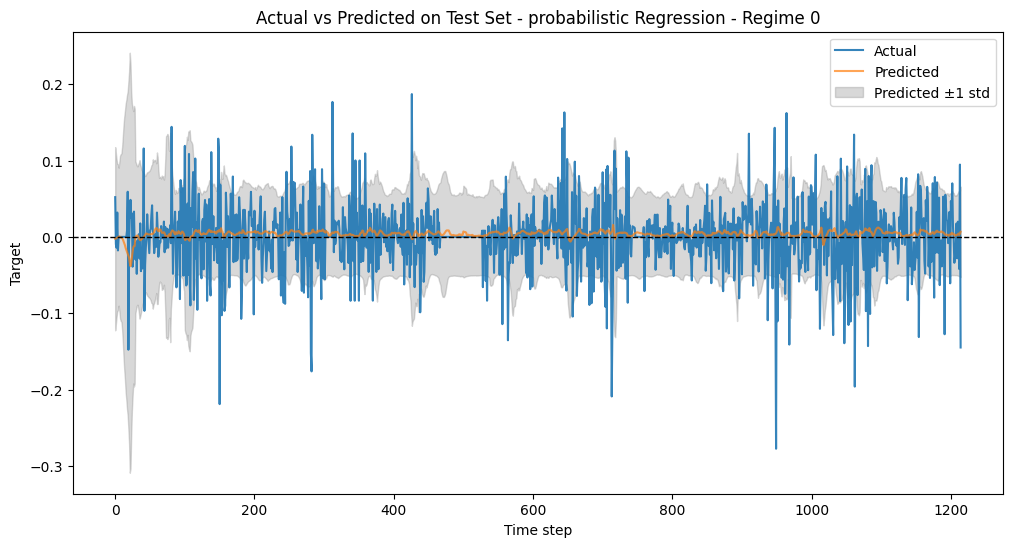

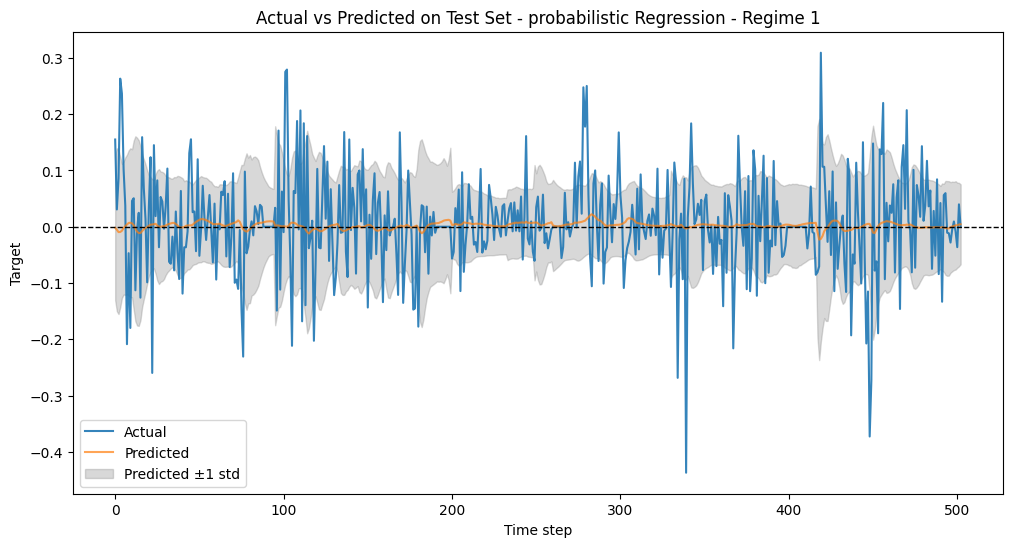


=== Test predictions for style: standard ===


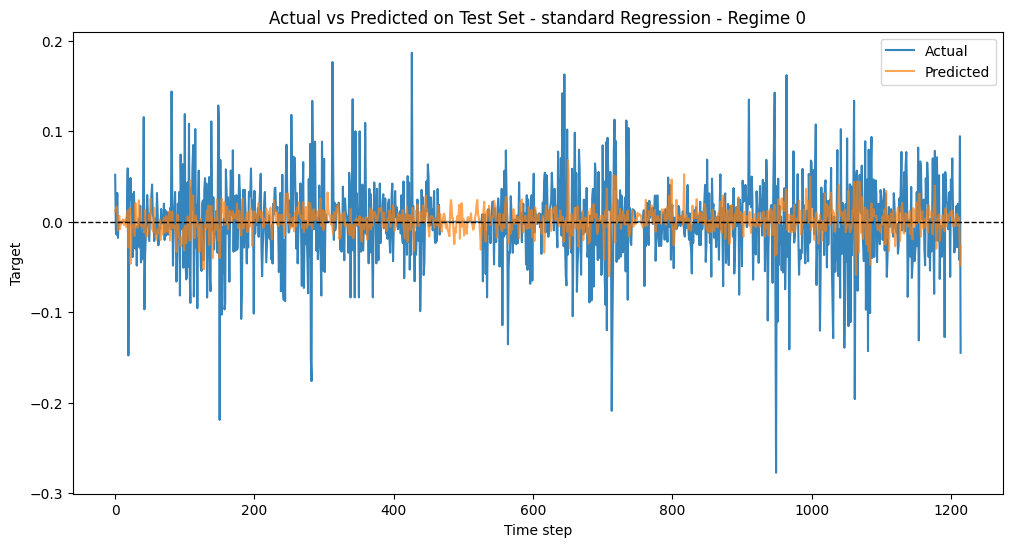

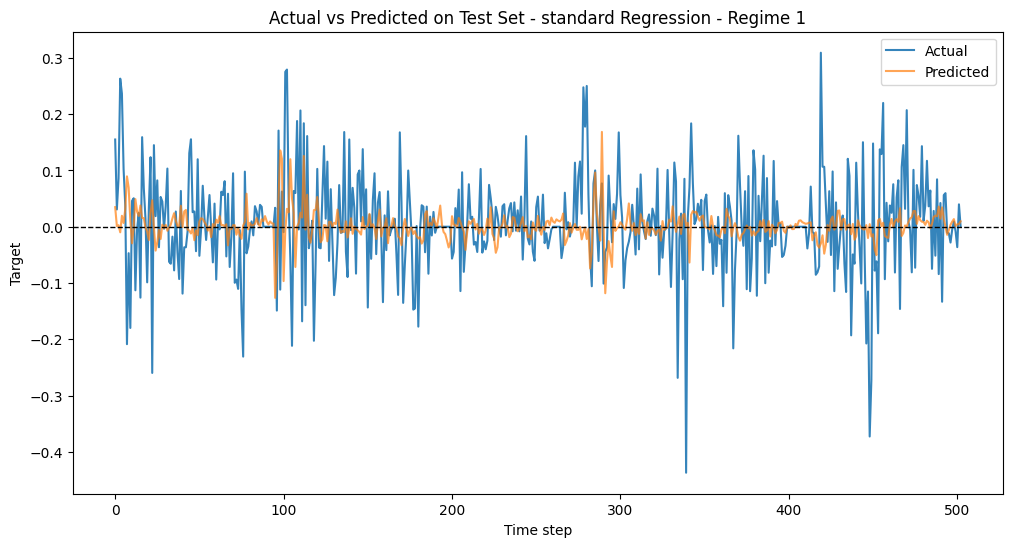

In [76]:
# For each regression style, predict and plot for each regime
for style, model_info in regime_best_models.items():
    params = model_info['best_params']
    model = model_info['model']
    model.eval()
    print(f"\n=== Test predictions for style: {style} ===")

    for regime in range(n_regimes):
        # Prepare regime-specific test sequences
        x_seq_test, y_seq_test = create_sequences(
            x_test_scaled, y_test, {regime: regime_blocks_test[regime]}, seq_len=seq_len)
        if len(x_seq_test) == 0:
            print(f"No test data for regime {regime}, skipping.")
            continue

        x_seq_test_torch = torch.from_numpy(x_seq_test.astype(np.float32)).to(device)
        y_seq_test_torch = torch.from_numpy(y_seq_test.astype(np.float32)).to(device)

        with torch.no_grad():
            if style == 'probabilistic':
                preds_test, var_test = model(x_seq_test_torch)
                y_pred = preds_test.cpu().numpy().flatten()
                var_pred = var_test.cpu().numpy().flatten()
            else:
                preds_test = model(x_seq_test_torch)
                y_pred = preds_test.cpu().numpy().flatten()
                var_pred = None

        y_true = y_seq_test_torch.cpu().numpy().flatten()

        plt.figure(figsize=(12, 6))
        plt.plot(y_true, label='Actual', alpha=0.9)
        plt.plot(y_pred, label='Predicted', alpha=0.7)
        if style == 'probabilistic' and var_pred is not None:
            plt.fill_between(np.arange(len(y_pred)),
                             y_pred - np.sqrt(var_pred),
                             y_pred + np.sqrt(var_pred),
                             color='gray', alpha=0.3, label='Predicted ±1 std')
        plt.axhline(y=y_test.mean(), color='k', linestyle='--', lw=1)
        plt.xlabel('Time step')
        plt.ylabel('Target')
        plt.title(f'Actual vs Predicted on Test Set - {style} Regression - Regime {regime}')
        plt.legend()
        plt.show()

- **Standard LSTM**  
  - Regime 0 (low vol): mean forecasts hover near zero, miss sharp dips/spikes.  
  - Regime 1 (high vol): underestimates amplitude, large swings go un-captured.

- **Probabilistic LSTM**  
  - Regime 0: narrow ±1 σ band in calm periods, widens on small jumps.  
  - Regime 1: substantial uncertainty around big spikes—useful risk signal despite biased mean.

**Takeaways & Next Steps**  
- Both models underfit tails. To nmitigate the issue, one could try to switch to different architectures and use attention layers. An example could be Temporal-Fusion Transformers.

## Trading strategy
Given the much worse prediction accuracy, we believe that there is no point in implementing any trading strategy in this case.